In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("postings.csv")

In [4]:
# df.head(3)

In [34]:
# INITIAL CLEANING

# Change format of column names for easier manipulation
df.columns = [col.strip().replace(" ","_").lower() for col in df.columns]
# Remove columns that are not relevant to the data analysis
df.drop(["job_location",'job_link',"first_seen","search_city"], axis=1, inplace = True)
# Rename Columns
df=df.rename(columns={"search_country":"country", "job_type": "regime"})
# Strip cell values
df=df.map(lambda x: x.strip() if isinstance(x, str) else x)
# df.head(3)

In [35]:
# SKILLS SERIES

# filling null values on job skills
df["job_skills"].fillna("non specified", inplace = True)

# Change cells in job_skills
df["job_skills"]=df["job_skills"].map(lambda x: x.split(", ") if isinstance(x, str) else x)
# df

In [36]:
# CREATE DATAFRAME (SQL TABLE) FOR THE UNIQUE "SKILLS" VALUES

# STEP 1: Create a set for the unique values of skills
skills_list = []
[skills_list.append(index)for item in df["job_skills"] for index in item]
  
skills_set = set(skills_list)
skills_set = sorted(skills_set)
# len(skills_set)

# STEP 2: Transforming a set into a pandas series
skills_series = pd.Series(skills_set, name = "skills")
skills_series

# STEP 3: Converting the pandas skills series to a pandas dataframe
skills_df = pd.DataFrame(skills_series).reset_index()
skills_df.rename(columns={"index":"skill_id", "skills": "skill_name"}, inplace = True)
# skills_df

In [37]:
# Export CSV
skills_df.to_csv("skills_df.csv",index = False)

In [38]:
# CREATE A DATAFRAME (SQL TABLE) FOR THE "JOB TITLE"
job_title_df = df["job_title"].reset_index()
job_title_df.rename(columns={"index":"job_title_id", "job_title": "job_title_name"}, inplace = True)
# job_title_df

In [39]:
# Export CSV
job_title_df.to_csv("job_title.csv",index=False)

In [40]:
# CREATE CONNECTOR DATAFRAME (SQL TABLE) BETWEEN "JOB TITLE" AND "SKILLS"

connector_df = pd.DataFrame()
row = 0
for item in df["job_skills"]:
    for index in item:     
        for skill in skills_df["skill_name"]:
            if skill == index:
                temp_dict = {"job_title":job_title_df["job_title_id"][row], "skill": skills_df["skill_id"][skills_df["skill_name"]==skill].index[0]}
                connector_df=connector_df._append(temp_dict, ignore_index= True)
    row +=1

# connector_df

In [41]:
# Reset index and renaming column
connector_df = connector_df.reset_index()
connector_df.rename(columns={"index":"connected_id"}, inplace = True)

In [42]:
# connector_df

In [43]:
# Export CSV
connector_df.to_csv("connector_df.csv",index=False)

In [47]:
# Create a new DataFrame data_branches
data_branches = pd.DataFrame()

# Define a function to map job titles to branch names
def map_branch(job_title):
    if 'analyst' in job_title.lower():
        return 'Analyst'
    elif 'engineer' in job_title.lower():
        return 'Engineer'
    elif 'scientist' in job_title.lower():
        return 'Scientist'
    elif 'intelligence' in job_title.lower():
        return 'Intelligence'
    else:
        return 'Other'

# Apply the function to create the 'branch_name' column in data_branches
data_branches['branch_name'] = df['job_title'].apply(map_branch)

# Reset the index and rename the former index column to 'branch_id'
data_branches.reset_index(inplace=True)
data_branches.rename(columns={'index': 'branch_id'}, inplace=True)

# Display the resulting DataFrame
# print(data_branches)
# data_branches["branch_name"].value_counts()

In [46]:
# ADDING COLUMNS ID'S TO "JOB TITLE DF" TO MAKE THE CONNECTIONS WITH TABLES
# Branch
# This was done when the data_branches was still with 6025 rows, for the other tables is below
branch_id_column =[]
for item in df["data_branches"]:  
    for name in data_branches["branch_name"]:
        if name == item:
            item = int(data_branches.index[data_branches["branch_name"]==name].tolist()[0])
            branch_id_column.append(item)
# branch_id_column

In [71]:
df["data_branches"]=data_branches["branch_name"]

In [73]:
# data_branches

In [74]:
data_branches=data_branches.groupby('branch_name').agg({"branch_id":"count"})
# data_branches

In [75]:
data_branches=data_branches.reset_index()

In [76]:
data_branches.drop('branch_id', axis=1, inplace=True)

In [77]:
data_branches = data_branches.reset_index()

In [78]:
data_branches.rename(columns={'index':'branch_id'}, inplace=True)

In [80]:
# data_branches

In [22]:
data_branches.to_csv("data_branches.csv",index=False)

In [86]:
# CREATE COUNTRY DATAFRAME (SQL TABLE)
country = pd.Series(df["country"].unique())
country = country.reset_index()
country.columns = ["country_id", "country_name"]
# country

In [87]:
# CREATE COMPANY DATAFRAME (SQL TABLE)
company = df[["company", "country"]]
company.columns = ["company_name", "country_name"]
company["country_name"]
def convert_cid(country_name):
    if country_name == "United States":
        return 0
    elif country_name == "Australia":
        return 1
    elif country_name == "United Kingdom":
        return 2
    else:
        return 3
        
company["country_id"] = company["country_name"].apply(convert_cid)
del company["country_name"]
company = company.reset_index()
company = company.rename(columns = {"index": "company_id"})
# company

C:\Users\ruijr\AppData\Local\Temp\ipykernel_10376\843491569.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company["country_id"] = company["country_name"].apply(convert_cid)


In [88]:
# CREATE JOB LEVEL DATAFRAME (SQL TABLE)
experience = pd.Series(df["job_level"].unique())
experience = experience.reset_index()
experience.columns = ["job_level_id", "job_level_name"]
# experience

In [89]:
# CREATE REGIME DATAFRAME (SQL TABLE)
regime = pd.Series(df["regime"].unique())
regime = regime.reset_index()
regime.columns = ["regime_id", "regime_name"]
# regime

In [90]:
# EXPORT CSV'S
# country.to_csv("country.csv", index = False)
# company.to_csv("company.csv", index = False)
# experience.to_csv("experience.csv", index = False)
# regime.to_csv("regime.csv", index = False)

In [91]:
# ADDING COLUMNS ID'S TO "JOB TITLE DF" TO MAKE THE CONNECTIONS WITH TABLES
# PART 1/2 - Creating the columns
# Create a function with the name of the column to not repeat the following code !!!

In [92]:
# Company
company_id_column =[]
for item in df["company"]:  
    for name in company["company_name"]:
        if name == item:
            item = int(company.index[company["company_name"]==name].tolist()[0])
            company_id_column.append(item)
# company_id_column

In [93]:
# Country
country_id_column =[]
for item in df["country"]:  
    for name in country["country_name"]:
        if name == item:
            item = int(country.index[country["country_name"]==name].tolist()[0])
            country_id_column.append(item)
# country_id_column

In [94]:
# Job_Level
job_level_id_column =[]
for item in df["job_level"]:  
    for name in experience["job_level_name"]:
        if name == item:
            item = int(experience.index[experience["job_level_name"]==name].tolist()[0])
            job_level_id_column.append(item)
# job_level_id_column

In [95]:
# Regime
regime_id_column =[]
for item in df["regime"]:  
    for name in regime["regime_name"]:
        if name == item:
            item = int(regime.index[regime["regime_name"]==name].tolist()[0])
            regime_id_column.append(item)
# regime_id_column

In [ ]:
# Branches
# Was already done above

In [ ]:
# ADDING COLUMNS ID'S TO "JOB TITLE DF" TO MAKE THE CONNECTIONS WITH TABLES
# PART 2/2 - Adding each company to the job_title_df 

In [96]:
# job_title_df

In [97]:
job_title_df["company_id"]=company_id_column

In [98]:
job_title_df["country_id"]=country_id_column

In [99]:
job_title_df["job_level_id"]=job_level_id_column

In [100]:
job_title_df["regime_id"]=regime_id_column

In [101]:
job_title_df.to_csv("job_title.csv", index = False)

In [ ]:
job_title_df["branch_id"]=branch_id_column

In [ ]:
# Export the job_title_df table to import on SQL
job_title_df.to_csv("job_title.csv", index = False)

In [102]:
# Example: confirming the names and id's with the codes below:
# df.iloc[1315]
# job_title_df.iloc[1315]
# company.iloc[1315]
# country
# experience
# regime
# df
# data_branches
# job_title_df

In [124]:
# WE EXPORTED CSV FILES FROM SQL AND THEN DID THE FOLLOWING CHARTS

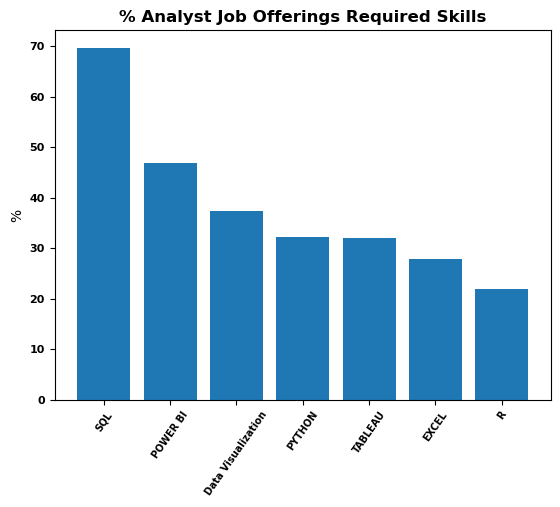

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# % Analyst Job Offerings Required Skills
df = pd.read_csv("SQL/csv_sql_tables/analyst_skill_count.csv")
df = df.T
df = df.reset_index()
df["index"]= df["index"].apply(lambda x: x.replace(" %","") if isinstance(x, str) else x)
df = df.sort_values(by=[0], ascending=False)
df

plt.bar(df["index"], df[0])
plt.xticks(rotation=55, fontsize=7, fontweight="bold")  # Rotate labels for readability
plt.yticks(fontweight="bold", fontsize=8)
plt.ylabel("%")
plt.title("% Analyst Job Offerings Required Skills", fontweight = "bold")
plt.show()

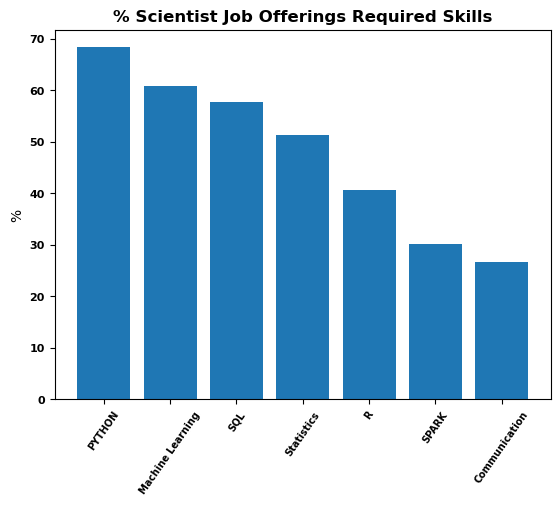

In [7]:
# % Scientist Job Offerings Required Skills
df = pd.read_csv("SQL/csv_sql_tables/scientist_skill_count (1).csv")
df = df.T
df = df.reset_index()
df["index"]= df["index"].apply(lambda x: x.replace(" %","") if isinstance(x, str) else x)
df = df.sort_values(by=[0], ascending=False)
df

plt.bar(df["index"], df[0])
plt.xticks(rotation=55, fontsize=7, fontweight="bold")  # Rotate labels for readability
plt.yticks(fontweight="bold", fontsize=8)
plt.ylabel("%")
plt.title("% Scientist Job Offerings Required Skills", fontweight = "bold")
plt.show()

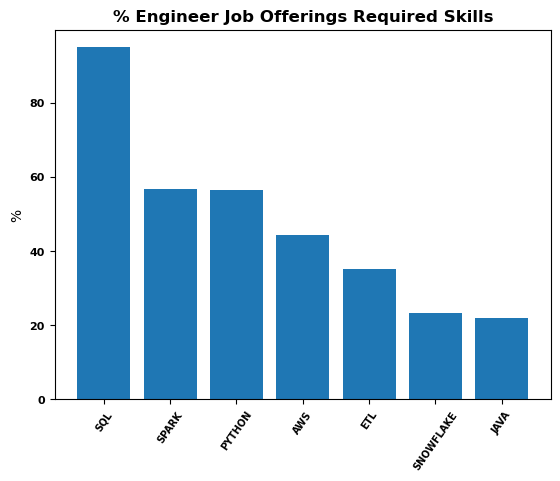

In [8]:
# % Engineer Job Offerings Required Skills
df = pd.read_csv("SQL/csv_sql_tables/engineer_skill_count.csv")
df = df.T
df = df.reset_index()
df["index"]= df["index"].apply(lambda x: x.replace(" %","") if isinstance(x, str) else x)
df = df.sort_values(by=[0], ascending=False)
df

plt.bar(df["index"], df[0])
plt.xticks(rotation=55, fontsize=7, fontweight="bold")  # Rotate labels for readability
plt.yticks(fontweight="bold", fontsize=8)
plt.ylabel("%")
plt.title("% Engineer Job Offerings Required Skills", fontweight = "bold")
plt.show()

,regime_id,regime_name,count
0,0,Onsite,52.85
1,1,Hybrid,32.20
2,2,Remote,14.95


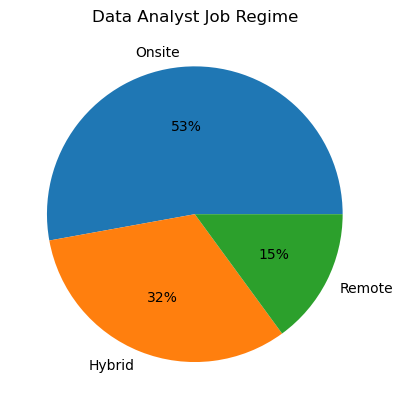

In [11]:
# Data Analyst Job Regime
df = pd.read_csv("SQL/csv_sql_tables/analys_job_regime (1).csv")
df.dtypes
my_labels = np.array(df["regime_name"])
plt.pie(df["count"], labels=my_labels, autopct='%1.0f%%')
plt.title('Data Analyst Job Regime')

my_labels

df

,regime_id,regime_name,count
0,0,Onsite,44.82
1,1,Hybrid,35.40
2,2,Remote,19.78


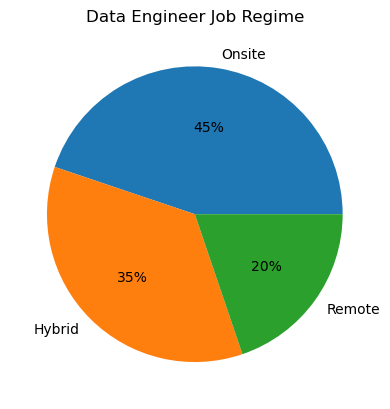

In [12]:
# Data Engineer Job Regime
df = pd.read_csv("SQL/csv_sql_tables/engineer_job_regime.csv")
df.dtypes
my_labels = np.array(df["regime_name"])
plt.pie(df["count"], labels=my_labels, autopct='%1.0f%%')
plt.title('Data Engineer Job Regime')

my_labels

df

,regime_id,regime_name,count
0,0,Onsite,40.70
1,1,Hybrid,29.15
2,2,Remote,30.15


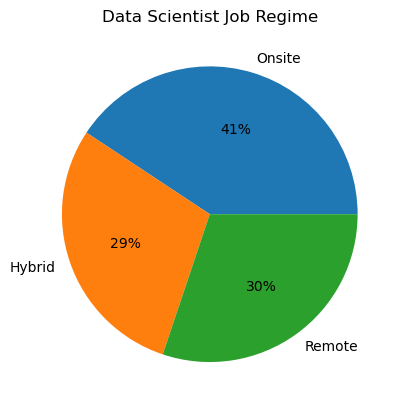

In [13]:
# Data Scientist Job Regime
df = pd.read_csv("SQL/csv_sql_tables/scientist_job_regime.csv")
df.dtypes
my_labels = np.array(df["regime_name"])
plt.pie(df["count"], labels=my_labels, autopct='%1.0f%%')
plt.title('Data Scientist Job Regime')

my_labels

df